In [ ]:
import matplotlib.pyplot as plt
from IPython.display import HTML
def show_HTML(anim):
    '''
    Convert matplotlib.animation.FuncAnimation 
    (e.g. from GammaSurface.show()) to HTML viewable object.

    anim: matplotlib.animation.FuncAnimation object
        Animation to convert to HTML
    '''
    html = anim.to_jshtml()
    # center the animation according to the width of the page
    # does not affect the size of the figure
    output_html = f'''
        <div style="display: flex; justify-content: center;">
        {html}
        </div>
        '''
    plt.close(fig=plt.gcf())
    return HTML(output_html)

# Generating Gamma Surfaces & Stacking Faults

Gamma surfaces (also called generalised stacking faults) and stacking faults are forms of crystal defects formed by sliding two slabs of a crystal against each other along a given plane. Often, these defects have metastable states (also called stacking faults), which can exist at grain boundaries or between two partial dislocations. Here, we deal with the full pathway from a complete crystal, sliding through any metastable points until we return back to the perfect crystal again. 

For a stacking fault, the slabs are moved along a single line, whereas for gamma surfaces this is the full plane (hence the name generalised stacking fault). `matscipy.gamma_surface` provides two classes - `GammaSurface` and `StackingFault` - in order to model these systems, including utility methods for relaxing and plotting the associated potential energy surfaces.


There are two main methodologies in generating structures representing gamma surfaces. Both methods start with first generating a structure that has a basis vector parallel to the miller index of the required gamma surface, which we achieve using `ase.build.cut` and `ase.build.rotate`.

## Method 1 - "Atom Move" Method
The first and most intuitive method involves splitting a supercell of this rotated structure into an upper and lower slab, and translating the top slab relative to the bottom. In the fully periodic case, this creates two stacking faults in the cell, at both the upper and lower boundaries of the top slab. We could instead choose to leave free surfaces above the top slab and below the bottom slab by removing the periodicity in the direction of the surface normal, which leaves us with a single gamma surface between the slabs.

## Method 2 - "Cell Move" Method
The second method method is more efficient as it reduces the number of atoms required, but is less intuitive to understand. Instead of moving atoms, we modify the cell vectors without moving the atoms. In doing this, we translate the periodic image of the bottom of the structure relative to the top of the structure, and vice versa, thus skipping the need to have two slabs. This method always produces a structure containing a single gamma surface, which is always at the cell boundaries. In order to model the free-surface approach, we can add vacuum to the center of the cell, which creates a similar two slab setup as method 1, but this time in a periodic cell.

NOTE: `GammaSurface` and `StackingFault` are extremely closely related as classes. To avoid these docs from becoming an API reference, lots of the additional features are spread across all examples. Though basic usage of the code can be achieved purely by copying the first example, the recommendation is to have a quick glance at all examples in order to see how the code may be parametised to suit your needs.

## Gamma Surface Example using Method 1
We will start with a very basic gamma surface, using the example of the (100) surface in FCC Aluminium, using the first method described above. We will use a model by [Kioseoglou et al](https://doi.org/10.1002/pssb.200844122) in order to perform some relaxations, and see what the surface looks like.

In [5]:
from matscipy.gamma_surface import StackingFault, GammaSurface
from matscipy.calculators.manybody.explicit_forms.tersoff_brenner import \
                            TersoffBrenner, Kioseoglou_PSSb_245_1118_AlN

from matscipy.calculators.manybody import Manybody
from matscipy.dislocation import get_elastic_constants

calc = Manybody(**TersoffBrenner(Kioseoglou_PSSb_245_1118_AlN))

alat, C11, C12, C44 = get_elastic_constants(calculator=calc, symbol="Al", verbose=False)

# Initialise a GammaSurface instance
# We could use (100) as the surface direction, but (001) should be equivalent
surface = GammaSurface(alat, surface_direction=(0, 0, 1), 
                       crystalstructure="fcc", symbol="Al")

# Attach the calculator to the surface, so we don't need to keep feeding it in later
surface.calc = calc 

To generate some stacking fault images, we use `GammaSurface.generate_images`. We will then use `GammaSurface.show()` to construct a nice `matplotlib.animation.FuncAnimation` showing the surface. We will also disable the periodicity in z to create free surfaces, which can be done via setting `vacuum=True`.

NOTE: The argument `vacuum` works differently depending on if you are using Method 1 (`cell_move=False`) or Method 2 (`cell_move=True`). For Method 1, `vacuum` toggles the periodicity in z on (`vacuum=False`) or off (`vacuum=True`), whereas for Method 2 is should be a float which gives the thickness of a vacuum layer to add in the center of the cell (between the periodic images of the gamma surfaces).

In [ ]:
# Images are also saved as surface.images
images = surface.generate_images(nx=8, ny=8, cell_move=False, vacuum=True)
anim = surface.show()
show_HTML(anim)

We can then use `GammaSurface.relax_images()` and `GammaSurface.get_energy_densities()` to perform some relaxations and then get the energy density profile using the calculator we attached. If no calculator was attached, we could instead pass one in using the `calculator=calc` argument.

By default, the code will apply the required constraints that all atoms only relax in the z direction, and to allow the cell to relax in z as well (the cell[2, 2] component). As we have a vacuum layer, the cell relaxation does not make sense, so we can disable this using `cell_relax=False`

In [ ]:
surface.relax_images(cell_relax=False)
E_densities = surface.get_energy_densities()

The code includes the function `GammaSurface.plot_energy_densities()` to generate a nice heatmap plot of the energy densities. However, we will reuse `GammaSurface.show`, this time including `plot_energies=True` to plot the energy densities alongside the relaxed structures.

In [ ]:
anim = surface.show(plot_energies=True)
show_HTML(anim)

## Stacking Fault Example using Method 2
We can see from the above plot that there appears to be a low energy paths along the diagonals of the plot, which correspond to the directions (110) and (1-10). We will attempt to measure the stacking fault energy density along this path using the `StackingFault` class. A stacking fault can be thought of as a special case of a gamma surface, and much of the content described in this section also applies to `GammaSurface`.

In the previous example, we only specified a surface direction and this was enough to form a reasonable basis. However, we explicitly want to orient the stacking fault to move in (110). To do this, we specify a `glide_direction`, which specifies the miller indices of the y direction of the cell.

In [ ]:

surface = StackingFault(alat, surface_direction=(0, 0, 1), glide_direction=(1, 1, 0),
                        crystalstructure="fcc", symbol="Al")

We will generate our stacking fault images using Method 2 described above, which is the fully periodic scheme using cell moves. This is activated using the `cell_move=True` argument of `generate_images`.

In the gamma surface example, there was very little distance between the stacking fault and the free surface. Normally, we aim to approximate gamma surfaces surrounded by lots of bulk in some way, so this approach leaves lots of room to improvement. We can extend the cell in the z direction using `z_reps`, which will move the periodic images of the surface apart. The images are purposefully kept very small in these examples for both speed and ease of visualisation, but in practice this should be set based on a convergence criterion.

Instead of having to call both `relax_images()` and `get_energy_densities()` ourselves, we can use the `relax=True` argument of `get_energy_densities()` to run the relaxation and get the energies in a single line.

In [ ]:
images = surface.generate_images(n=16, cell_move=True, z_reps=4)
# Calc not attached, so can pass it here
Es = surface.get_energy_densities(relax=True, calculator=calc) 

By default, both the `plot_energy_densities()` and `show(plot_energies=True)` methods of the `GammaSurface` and `StackingFaults` use energy density units of eV/A$^2$, but often literature will give numbers in the SI units J/m$^2$. To convert to SI in the plots, we can use the `si=True` argument.

RuntimeError: Cannot plot energy densities before get_energy_densities is called!

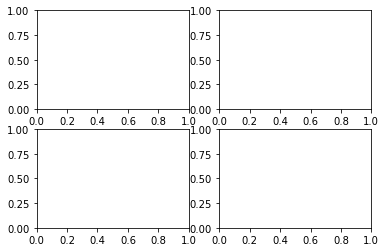

In [6]:
anim = surface.show(plot_energies=True, si=True)
show_HTML(anim)